In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

During the 2020 NFL season, due to covid, we had the unique oppurtunity to see what NFL games are like with no fans. Many players talked about how different the atmosphere was during games, and how it felt like a "highschool scrimage". Fans are often told how much they impact them game, and as a fan myself the idea that you have such an impact is a pretty awesome idea. So i wanted to look deeper into the impact fans.

This will be pretty difficult to answer as a single season isnt a huge sample size, but i doubt we will ever see an NFL game without fans again. With how often gameplans change i will only be using recent NFL seasons to try and limit this variation.

Hypothesis
1. With the lack of crowd noise i believe that offenses will be able to communicate better, increasing total yards
2. Offensive lines be better prepared for the snap leading to less penalties and sacks allowed
3. Crowd noise is a large detriment to away teams, and away teams will have a larger winning percentage without a crowd

In [27]:
df = pd.read_csv("./data_sets/nfl_team_stats_2002-2022.csv")
pd.set_option('display.max_columns', 70)
sns.set_style("whitegrid")
sns.set_palette("Set2")

In [38]:
cols_to_split = [
{
    "name": "third_downs",
    "first_split": "third_down_conv",
    "second_split": "third_down_attempt"
},
{
    "name": "fourth_downs",
    "first_split": "fourth_down_conv",
    "second_split": "fourth_down_attempt"
},
{
    "name": "sacks",
    "first_split": "sacks",
    "second_split": "sack_yards"
},
{
    "name": "comp_att",
    "first_split": "pass_comp",
    "second_split": "pass_attempt"
},
{
    "name": "penalties",
    "first_split": "penalties",
    "second_split": "penalty_yards"
},
{
    "name": "redzone",
    "first_split": "redzone_conv",
    "second_split": "redzone_attempt"
},
]

def split_col(col, df):
    name = col['name']
    first_split = col['first_split']
    second_split = col['second_split']

    split = df[name].str.split("-", expand = True)
    df = df.drop(name, axis=1)
    df[first_split] = split[0].astype(int)
    df[second_split] = split[1].astype(int)
    return df

In [50]:
df['date']= pd.to_datetime(df['date'])

#NFL season goes into next year so include janurary and february games in with previous year
df['year'] = np.where(df['date'].dt.month > 2 , df['date'].dt.year, df['date'].dt.year - 1)

df['won'] = np.where(df['score_away'] < df['score_home'], "home", "away")

#Kickoff moved up to 35 yard line in 2011 so i am only including data used from then on
df = df[df['year'] >= 2011]

#splitting original df into home and away
away_cols = df.columns[df.columns.str.contains("away")]
home_cols = df.columns[df.columns.str.contains("home")]

away_df = df.drop(home_cols, axis=1)
home_df = df.drop(away_cols, axis=1)

away_df.rename(columns={'away': 'team'}, inplace=True)
home_df.rename(columns={'home': 'team'}, inplace=True)

away_df['des'] = 'away'
away_df['won'] = df['won'] == 'away'

home_df['des'] = 'home'
home_df['won'] = df['won'] == 'home'

away_df.columns = away_df.columns.str.replace("_away", "")
home_df.columns = home_df.columns.str.replace("_home", "")

for col in cols_to_split:
   away_df = split_col(col, away_df)
   home_df = split_col(col, home_df)

home_away_df = pd.concat([home_df, away_df]).reset_index(drop=True)

yearly_df = home_away_df.drop(columns=["date", "team", "possession", "des", "won"]).groupby("year").mean().reset_index()

yearly_df.head()

,year,first_downs,passing_yards,rushing_yards,total_yards,rushing_attempts,fumbles,int,turnovers,drives,def_st_td,score,third_down_conv,third_down_attempt,fourth_down_conv,fourth_down_attempt,sacks,sack_yards,pass_comp,pass_attempt,penalties,penalty_yards,redzone_conv,redzone_attempt
0,2011,19.500000,231.131579,117.015038,348.146617,27.266917,0.597744,0.977444,1.575188,12.043233,0.353383,22.199248,5.056391,13.272556,0.362782,0.843985,2.334586,15.231203,20.526316,34.152256,6.338346,53.501880,1.650376,3.171053
1,2012,19.962547,232.432584,116.898876,349.331461,27.301498,0.646067,0.908240,1.554307,11.893258,0.443820,22.887640,5.084270,13.284644,0.438202,0.893258,2.260300,14.584270,21.176030,34.782772,6.220974,52.627341,0.000000,0.000000
2,2013,19.966292,235.782772,113.335206,349.117978,27.131086,0.602996,0.975655,1.578652,12.123596,0.406367,23.434457,5.205993,13.571161,0.447566,0.940075,2.511236,16.447566,21.640449,35.323970,6.088015,52.511236,1.790262,3.237828
3,2014,20.058052,236.902622,111.172285,348.074906,26.694757,0.606742,0.889513,1.496255,11.576779,0.329588,22.634831,5.335206,13.337079,0.411985,0.880150,2.361423,14.932584,21.893258,34.958801,6.602996,55.338951,1.702247,3.151685
4,2015,19.998127,242.805243,108.513109,351.318352,26.327715,0.612360,0.857678,1.470037,11.765918,0.372659,22.732210,5.189139,13.387640,0.460674,0.945693,2.338951,15.625468,22.466292,35.777154,6.876404,58.456929,1.719101,3.071161


In [51]:
yearly_df.shape

(12, 24)

In [52]:
yearly_df.dtypes

year                     int32
first_downs            float64
passing_yards          float64
rushing_yards          float64
total_yards            float64
rushing_attempts       float64
fumbles                float64
int                    float64
turnovers              float64
drives                 float64
def_st_td              float64
score                  float64
third_down_conv        float64
third_down_attempt     float64
fourth_down_conv       float64
fourth_down_attempt    float64
sacks                  float64
sack_yards             float64
pass_comp              float64
pass_attempt           float64
penalties              float64
penalty_yards          float64
redzone_conv           float64
redzone_attempt        float64
dtype: object

In [54]:
yearly_df.columns

Index(['year', 'first_downs', 'passing_yards', 'rushing_yards', 'total_yards',
       'rushing_attempts', 'fumbles', 'int', 'turnovers', 'drives',
       'def_st_td', 'score', 'third_down_conv', 'third_down_attempt',
       'fourth_down_conv', 'fourth_down_attempt', 'sacks', 'sack_yards',
       'pass_comp', 'pass_attempt', 'penalties', 'penalty_yards',
       'redzone_conv', 'redzone_attempt'],
      dtype='object')

In [55]:
yearly_df.isna().sum()

year                   0
first_downs            0
passing_yards          0
rushing_yards          0
total_yards            0
rushing_attempts       0
fumbles                0
int                    0
turnovers              0
drives                 0
def_st_td              0
score                  0
third_down_conv        0
third_down_attempt     0
fourth_down_conv       0
fourth_down_attempt    0
sacks                  0
sack_yards             0
pass_comp              0
pass_attempt           0
penalties              0
penalty_yards          0
redzone_conv           0
redzone_attempt        0
dtype: int64

In [11]:
yearly_.describe()

,year,first_downs,passing_yards,rushing_yards,total_yards,rushing_attempts,fumbles,int,turnovers,drives,def_st_td,score,third_down_conv,third_down_attempt,fourth_down_conv,fourth_down_attempt,sacks,sack_yards,pass_comp,pass_attempt,penalties,penalty_yards,redzone_conv,redzone_attempt
count,320.00000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,2017.50000,20.165535,233.938058,112.983348,346.921406,26.514869,0.557692,0.839012,1.396704,11.377986,0.268155,22.790166,5.152727,13.068155,0.560244,1.104691,2.373989,15.699835,22.095558,34.889504,6.325421,53.921367,1.800368,3.179354
std,2.87678,2.153187,34.799527,20.537297,34.477382,3.010118,0.180202,0.280096,0.357317,0.674715,0.199358,4.133395,0.659450,0.878013,0.233790,0.383387,0.630492,4.541001,2.850779,3.747759,0.960096,8.853705,0.463718,0.539462
min,2013.00000,14.937500,130.529412,72.250000,241.562500,20.062500,0.125000,0.250000,0.588235,9.705882,0.000000,14.000000,3.250000,11.055556,0.055556,0.235294,0.823529,6.352941,13.117647,22.176471,3.875000,33.375000,0.812500,1.750000
25%,2015.00000,18.724507,207.575658,98.098039,323.062500,24.477941,0.437500,0.631579,1.125000,10.937500,0.117647,19.785846,4.722222,12.470588,0.388889,0.823529,1.887255,12.235294,20.098958,32.204770,5.718137,48.365196,1.492647,2.812500
50%,2017.50000,20.181985,233.086806,110.718750,347.183824,26.000000,0.555556,0.812500,1.352941,11.324561,0.235294,22.562500,5.125000,13.000000,0.500000,1.052778,2.333333,15.472136,22.187500,35.091912,6.312500,54.060458,1.750000,3.154762
75%,2020.00000,21.562500,257.960526,124.651961,371.080882,28.630515,0.687500,1.000000,1.625000,11.795230,0.375000,25.630515,5.593954,13.671875,0.705882,1.312500,2.823529,18.572917,23.802083,37.776654,6.942724,59.385691,2.133224,3.555556
max,2022.00000,26.631579,334.368421,204.764706,447.000000,36.764706,1.125000,1.875000,2.750000,13.562500,1.000000,34.947368,6.687500,15.812500,1.352941,2.470588,4.437500,30.250000,29.666667,45.388889,9.250000,83.875000,3.166667,4.631579


In [12]:
yearly_.head()

,team,year,first_downs,passing_yards,rushing_yards,total_yards,rushing_attempts,fumbles,int,turnovers,drives,def_st_td,score,third_down_conv,third_down_attempt,fourth_down_conv,fourth_down_attempt,sacks,sack_yards,pass_comp,pass_attempt,penalties,penalty_yards,redzone_conv,redzone_attempt
0,49ers,2013,18.157895,185.736842,139.736842,325.473684,31.421053,0.578947,0.578947,1.157895,11.526316,0.421053,24.684211,4.842105,13.052632,0.526316,0.789474,2.368421,13.526316,15.210526,26.368421,6.157895,50.526316,1.842105,3.473684
1,49ers,2014,18.937500,191.437500,136.000000,327.437500,29.375000,0.750000,0.625000,1.375000,11.125000,0.375000,19.125000,5.375000,13.312500,0.625000,1.125000,3.250000,21.500000,18.250000,30.437500,7.250000,58.562500,1.187500,2.750000
2,49ers,2015,16.312500,207.250000,96.500000,303.750000,24.375000,0.312500,0.750000,1.062500,11.437500,0.125000,14.875000,4.062500,13.312500,0.562500,1.187500,3.312500,20.625000,20.125000,32.875000,7.062500,51.437500,1.062500,2.437500
3,49ers,2016,17.937500,181.937500,126.187500,308.125000,28.625000,0.937500,0.625000,1.562500,12.500000,0.000000,19.312500,4.875000,13.875000,0.625000,1.187500,2.937500,15.937500,17.937500,30.687500,6.187500,51.937500,1.875000,2.750000
4,49ers,2017,20.062500,245.312500,104.000000,349.312500,25.500000,0.500000,0.937500,1.437500,11.500000,0.062500,20.687500,5.687500,14.625000,0.500000,1.125000,2.687500,19.375000,22.625000,37.937500,7.687500,61.750000,1.500000,3.187500


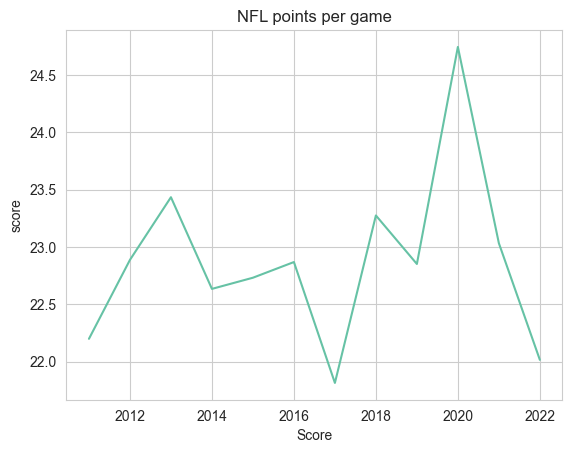

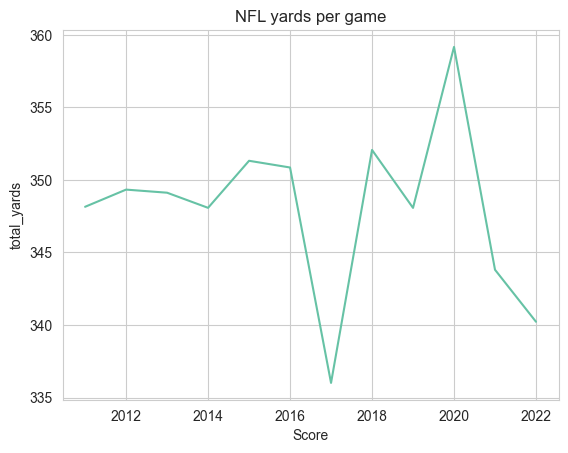

In [57]:
sns.lineplot(yearly_df, x="year", y="score")
plt.xlabel("Score")
plt.title("NFL points per game")
plt.show()

sns.lineplot(yearly_df, x="year", y="total_yards")
plt.xlabel("Score")
plt.title("NFL yards per game")
plt.show()

univarate Graphics

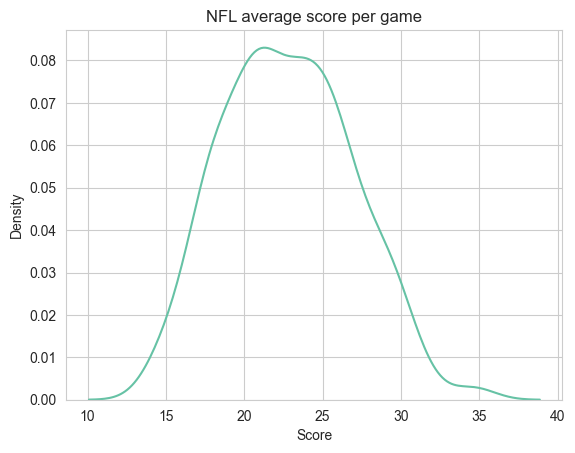

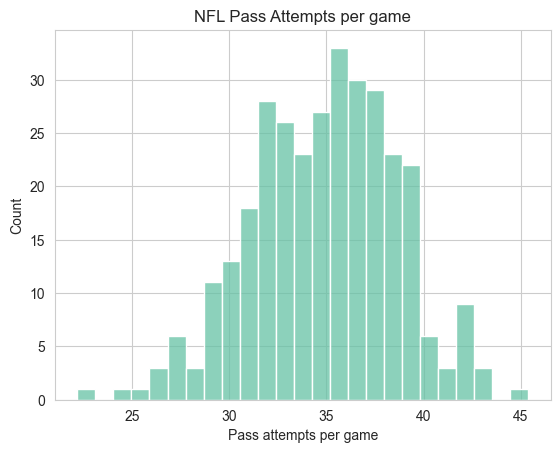

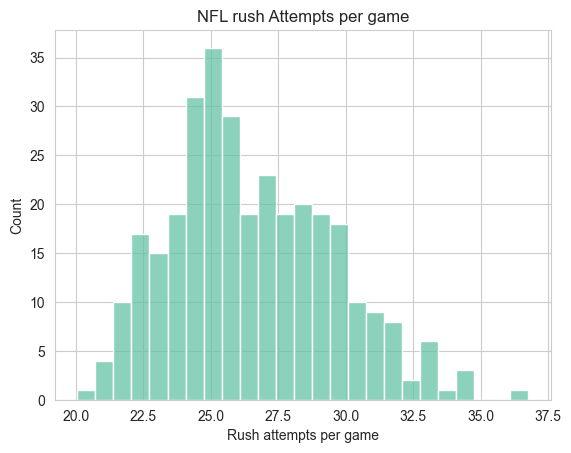

In [14]:
sns.kdeplot(df, x="score")
plt.xlabel("Score")
plt.title("NFL average score per game")
plt.show()

sns.histplot(df, x="pass_attempt", bins=25)
plt.xlabel("Pass attempts per game")
plt.title("NFL Pass Attempts per game")
plt.show()

sns.histplot(df, x="rushing_attempts", bins=25)
plt.xlabel("Rush attempts per game")
plt.title("NFL rush Attempts per game")
plt.show()




Yard and score changes over years

Text(0, 0.5, 'Points Per Game')

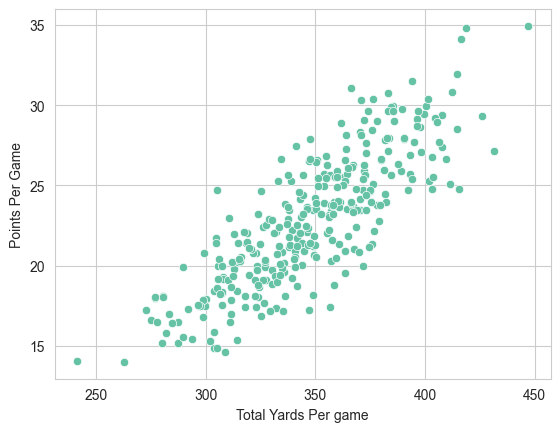

In [15]:
sns.scatterplot(df, x="total_yards", y="score")
plt.xlabel("Total Yards Per game")
plt.ylabel("Points Per Game")

In [16]:
sns.lineplot(yearly_stats_df, x="year", y="passing_yards")
plt.xticks(rotation="vertical")
plt.xlabel("Year")
plt.ylabel("Yards")
plt.title("Nfl passing by year")
plt.show()

sns.lineplot(yearly_stats_df, x="year", y="score")
plt.xticks(rotation="vertical")
plt.ylabel("Score")
plt.title("Nfl Scoring by year")
plt.show()

sns.lineplot(yearly_stats_df, x="year", y="turnovers")
plt.xticks(rotation="vertical")
plt.ylabel("turnovers")
plt.title("Nfl turnovers by year")
plt.show()


#drive numbers before 2005 seem to be incorrect
sns.lineplot(yearly_stats_df, x="year", y="drives")
plt.xticks(rotation="vertical")
plt.ylabel("drives")
plt.title("Nfl drives by year")
plt.show()

NameError: name 'yearly_stats_df' is not defined

c:\Users\Intern\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


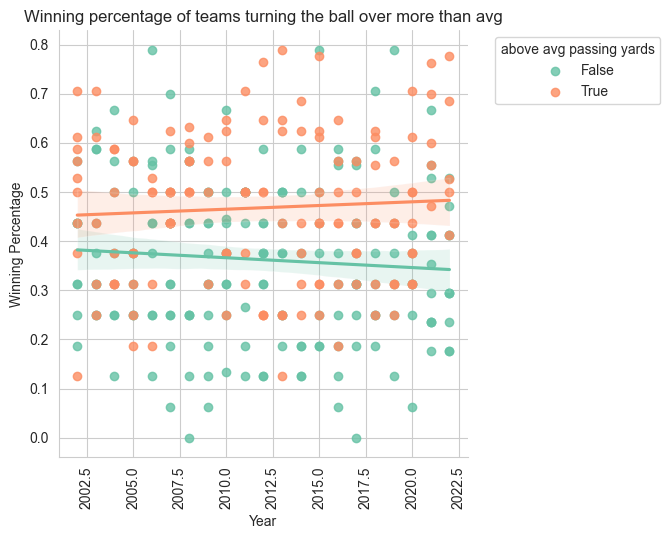

In [ ]:
data_avg = yearly_stats_df.groupby('year')[['turnovers', "passing_yards"]].mean().rename(columns={"turnovers": "avg_to", "passing_yards": "avg_passing"}).reset_index()
query = pd.merge(yearly_stats_df, data_avg, on="year").query("turnovers > avg_to").copy()

query["above_passing"] = query["passing_yards"] > query["avg_passing"]
query['year'] = query['year'].astype(int)

sns.lmplot(query, x="year", y="won", hue="above_passing", legend=False)
plt.title("Winning percentage of teams turning the ball over more than avg")
plt.xlabel("Year")
plt.ylabel("Winning Percentage")
plt.legend(title="above avg passing yards", bbox_to_anchor=(1.05, 1))
plt.xticks(rotation="vertical")
plt.show()


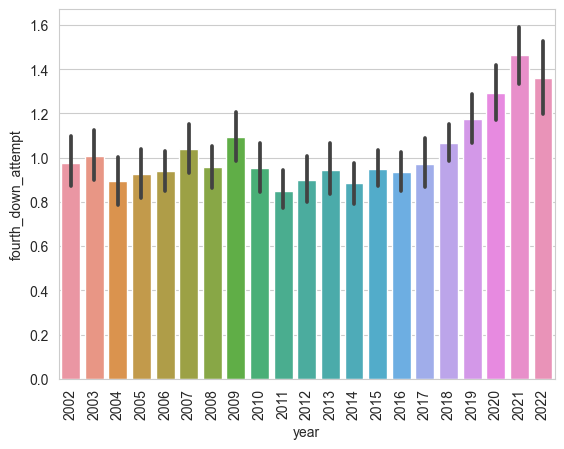

In [ ]:
sns.barplot(yearly_stats_df, x="year", y="fourth_down_attempt")
plt.xticks(rotation="vertical")
plt.show()



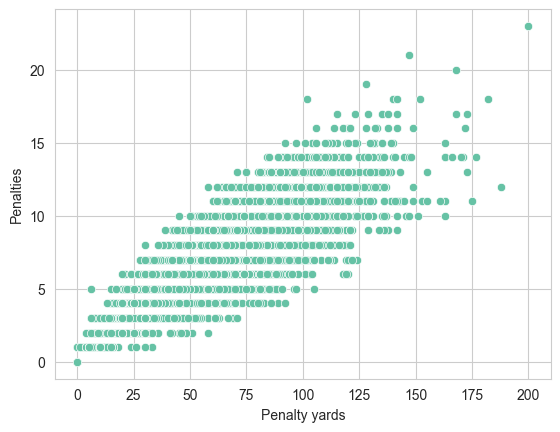

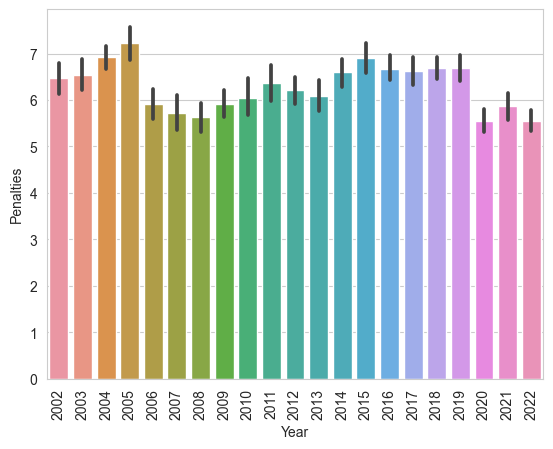

In [ ]:
#are less penalized games more likey to result in sacks

sns.scatterplot(weekly_stats_df, y="penalties", x="penalty_yards")
plt.xlabel("Penalty yards")
plt.ylabel("Penalties")
plt.show()

sns.barplot(yearly_stats_df, y="penalties", x="year")
plt.xlabel("Year")
plt.ylabel("Penalties")
plt.xticks(rotation="vertical")
plt.show()

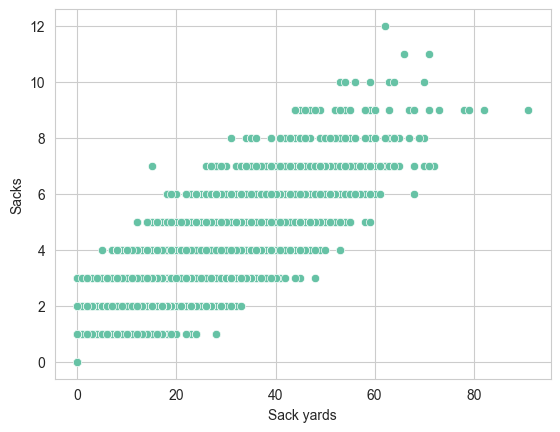

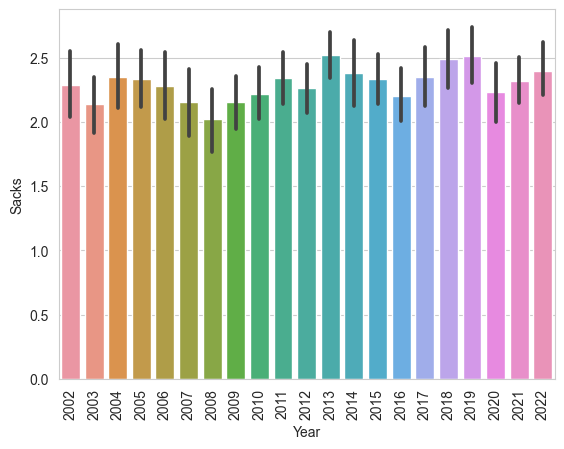

In [ ]:
sns.scatterplot(weekly_stats_df, y="sacks", x="sack_yards")
plt.xlabel("Sack yards")
plt.ylabel("Sacks")
plt.show()

sns.barplot(yearly_stats_df, y="sacks", x="year")
plt.xlabel("Year")
plt.ylabel("Sacks")
plt.xticks(rotation="vertical")
plt.show()

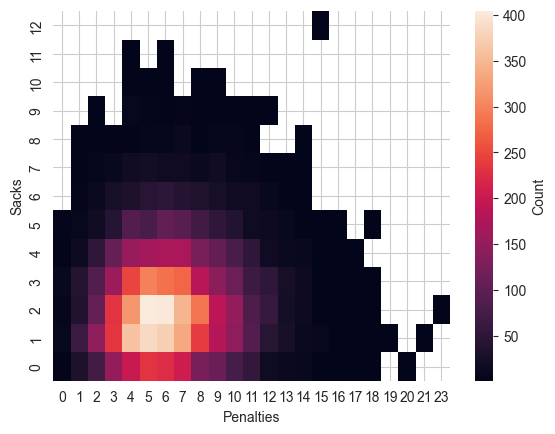

In [ ]:
data = weekly_stats_df.pivot_table(index='sacks', columns='penalties', values="team", aggfunc='count')

g = sns.heatmap(data, cbar_kws=dict(label='Count'))
g.invert_yaxis()
plt.xlabel("Penalties")
plt.ylabel("Sacks")
plt.show()

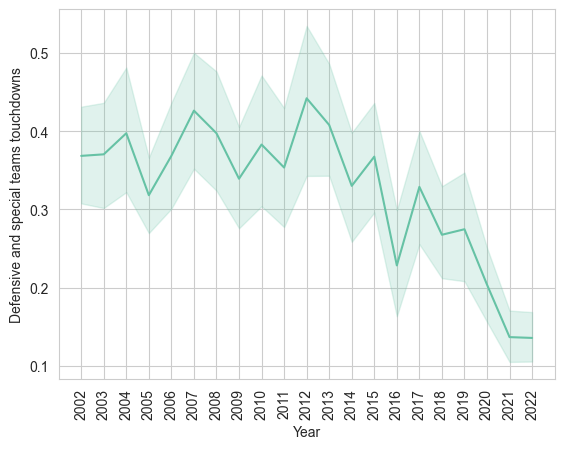

In [ ]:
sns.lineplot(yearly_stats_df, x="year", y="def_st_td")
plt.xticks(rotation="vertical")
plt.xlabel("Year")
plt.ylabel("Defensive and special teams touchdowns")
plt.show()